In [1]:
# !pip install --no-cache-dir --force-reinstall --upgrade\
#   "git+https://github.com/Sea-Meets-the-Stars/llc4320-native-grid-preprocessing.git@data_loader"


In [2]:
import dbof.dataset_creation.zarr_dataset as zarr_dataset
import dbof.io.filesystems as filesystems

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
bucket = "dbof" #data_cfg["bucket"]
folder = "native_grid_dbof_training_data"
s3_endpoint = "https://s3-west.nrp-nautilus.io"
feature_channels = ['Eta', 'Salt', 'Theta', 'U', 'V', 'W', 'relative_vorticity', 'log_gradb']
run_id = "big_run_00"

fs, fs_synch = filesystems.create_s3_filesystems(s3_endpoint)

reader = zarr_dataset.ZarrDatasetReader(
    bucket=bucket,
    folder=folder,
    run_id=run_id,
    dataset_name="dataset_creation.zarr",
    fs=fs
)

In [6]:
# import time
#
# t0 = time.time()
# _ = images_da[1024:2084].compute()   # load ~100 samples
# t1 = time.time()
#
# print("1024 samples took", t1 - t0, "seconds")

# Dataloader


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class DBOFCutoutInMemoryDataset(Dataset):

    def __init__(self, reader, transform=None):
        client = Client()

        self.reader = reader
        self.transform = transform

        images_da, ids_da, valid_mask_da = reader.full_dataset_as_dask()

        # subset for now
        print("Loading Images into memory...")
        images_np = images_da[:5120].compute()
        print("Loading ids into memory...")
        ids_np = ids_da[:5120].compute()
        mask = (ids_np != b"")

        self.images = images_np[mask]
        self.ids = ids_np[mask]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Convert to torch tensor
        x = torch.as_tensor(self.images[idx])

        if x.dtype != torch.float32:
            x = x.float()

        if self.transform is not None:
            x = self.transform(x)

        return x

def make_dbof_cutout_dataloader(reader, batch_size=64, num_workers=0, transform=None):
    dataset = DBOFCutoutInMemoryDataset(reader, transform=transform)

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,          # works (map-style)
        drop_last=True,        # common for SSL/DINO
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=(num_workers > 0),
    )
    return loader

In [8]:
loader = make_dbof_cutout_dataloader(reader, batch_size=64, num_workers=0, transform=None)

Loading Images into memory...
Loading ids into memory...


In [21]:
# for x in loader:
#     for i in x[0]:
#         plt.figure(figsize=(8,8), dpi= 90)
#         plt.imshow(i,origin='lower',cmap='jet')
#     break

In [22]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


In [12]:
# A dataset run generates many metadata files.
files = fs_synch.glob(
    f"{bucket}/{folder}/{run_id}/metadata/*.parquet"
)

meta_df = pd.read_parquet(files, filesystem=fs_synch)

AttributeError: 'ZarrDatasetReader' object has no attribute 'num_valid_images'

In [16]:
meta_df

In [17]:
lats = meta_df["center_lat"].values
lons = meta_df["center_lon"].values


cmap = plt.get_cmap("tab10")

fig = plt.figure(figsize=(11, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()
ax.coastlines()

sc = ax.scatter(
    lons,
    lats,
    cmap=cmap,
    s=8,
    alpha=0.05,
    transform=ccrs.PlateCarree()
)

plt.title("Sampled Points By Year \nBias = 1.3")
plt.show()

,id,dataset_index,native_grid,center_grid_face,center_grid_j,center_grid_i,center_lat,center_lon,target_km_res,real_km_w,real_km_h,pre_interp_res,log_grad_b_2_center,time_snapshot
0,e70c41cc-7f9e-4622-b627-d82b3c2ce816,b'80320ed3b4be436a926176a3a9c83567',LLC4320,11,1097,2248,-28.155027,-105.135414,150,148.354039,147.033448,"[73, 80]",-20.052276,2012-06-17 16:00:00
1,44b77a4a-d5bb-4b2e-b521-28bbc5637bf3,b'77a9da2ab6ad4d7794eaf923f80a51b3',LLC4320,1,251,1312,-54.159893,-10.656250,150,149.181122,148.791059,"[116, 111]",-21.654043,2012-06-17 16:00:00
2,39a9d65f-5136-4fe2-8cbf-0266980788eb,b'0319fe0901d048548e3c4c0f7dea1e7e',LLC4320,10,749,4172,16.468592,-112.385414,150,147.159049,146.597618,"[67, 73]",-18.828841,2012-06-17 16:00:00
3,f9f7156b-3e3a-4ca5-bc24-448902291ca1,b'caa8c5e1828842ffad3e780e10f991d5',LLC4320,1,2265,881,-24.830193,-19.635416,150,147.145571,146.836834,"[77, 71]",-21.323843,2012-06-17 16:00:00
4,c1ee1668-bb01-490f-97ff-9a7b2c53d98c,b'4d92d6016dbe409489011ae03335b975',LLC4320,8,2299,2988,-39.897797,-170.093750,150,148.125554,149.264893,"[85, 91]",-20.722053,2012-06-17 16:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99895,ce95f2d3-e050-46e8-8185-13bab831d89a,b'7eeee4274ad14748a2df854163bd2958',LLC4320,2,3966,1925,68.759949,1.467111,150,149.956650,149.262616,"[142, 159]",-19.275528,2012-07-02 07:00:00
99896,65bf61a0-68b5-45ea-83ca-e71b4fb335d2,b'e3e82b8a34ff41dea9769af54e2a2033',LLC4320,10,4036,1998,50.452835,-43.906250,150,148.849201,147.475342,"[101, 108]",-18.881853,2012-07-02 07:00:00
99897,46176f23-9154-450f-b31a-1b26d3e5905a,b'80a5e7470c4e43d7b6c4e48095ac5039',LLC4320,2,4207,1681,70.770042,-5.020141,150,149.782344,148.938694,"[153, 165]",-16.874352,2012-07-02 07:00:00
99898,72a8772a-acc1-40cd-b43d-628b164f2466,b'5747da898469416a9c650a32ed1fa8e5',LLC4320,1,2136,895,-27.051636,-19.343750,150,148.521498,147.917216,"[79, 73]",-20.631351,2012-07-02 07:00:00


C:\Users\Jake Tallman\AppData\Local\Programs\Python\Python313\Lib\site-packages\cartopy\mpl\geoaxes.py:1677: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


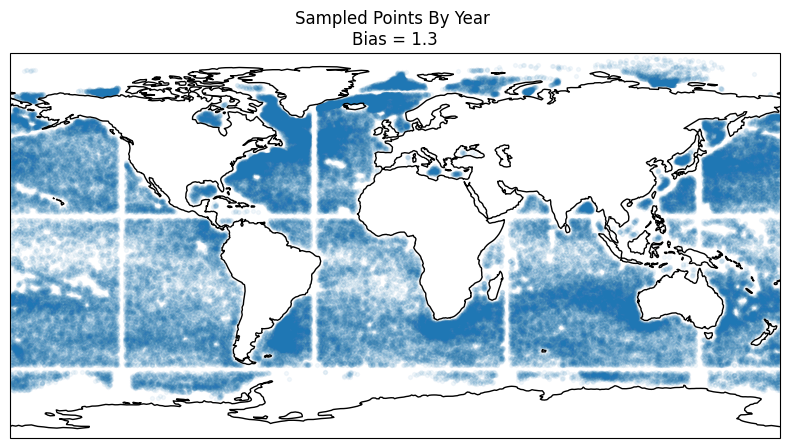

In [28]:
import cmocean


def plot_image_features(imgs, ids):
    """
    imgs: (N, C, H, W)
    """

    N, C, H, W = imgs.shape

    fig = plt.figure(figsize=(2.5*(C+1), 2.5*N))
    gs = fig.add_gridspec(N, C + 1, wspace=0.5, hspace=0.15)

    for i in range(N):
        row_data = imgs[i]

        for c in range(C):
            ax = fig.add_subplot(gs[i, c])

            # vmin = np.nanmin(row_data[c])
            # vmax = np.nanmax(row_data[c])


            if c == 0:
                cmap = cmocean.cm.gray
            elif c == 1 :
                cmap = cmocean.cm.haline
            elif c == 2 :
                cmap = cmocean.cm.thermal
            elif c == 6 :
                cmap = cmocean.cm.diff
            else :
                cmap = cmocean.cm.speed



            im = ax.imshow(row_data[c], cmap=cmap) #, vmin=vmin, vmax=vmax)
            ax.set_xticks([])
            ax.set_yticks([])

            if i == 0:
                ax.set_title(f"{feature_channels[c]}", fontsize=10)

            fig.colorbar(
                im,
                ax=ax,
                fraction=0.046,
                pad=0.01 #format="%4.2"
            )

    plt.show()

rand_indices = np.random.randint(0, reader.num_images, size=4)
imgs, ids = reader.get_images(rand_indices)

plot_image_features(imgs, ids)

# Metadata for each sample
subset_df = (
    meta_df
    .set_index("dataset_index")
    .loc[ids]
    .reset_index()
)
subset_df

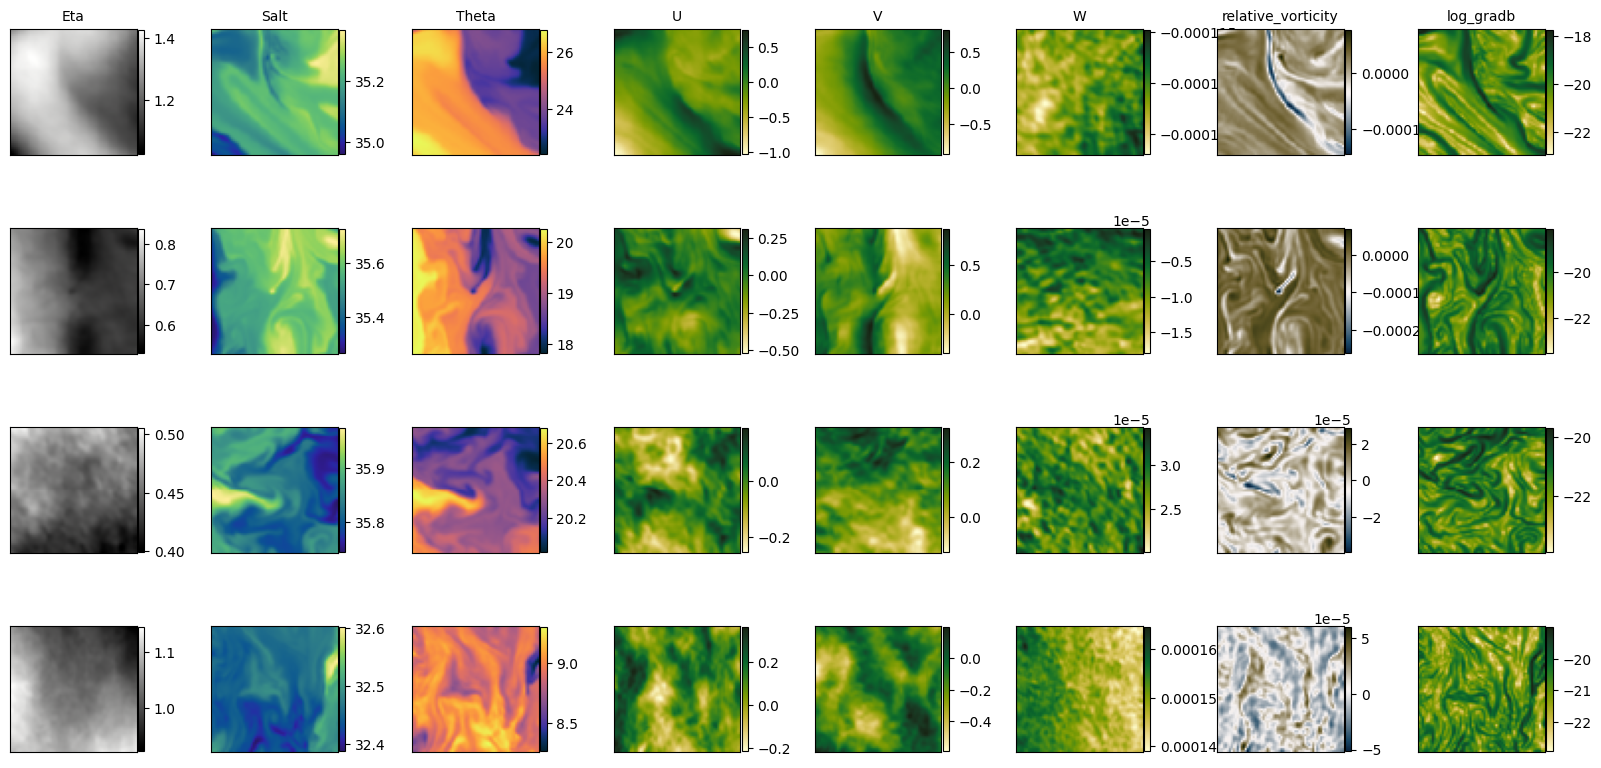

,dataset_index,id,native_grid,center_grid_face,center_grid_j,center_grid_i,center_lat,center_lon,target_km_res,real_km_w,real_km_h,pre_interp_res,log_grad_b_2_center,time_snapshot
0,b'c9d7a0aa09ef4187a59d669ada616f26',4820088e-7e7d-4261-aab9-eea1c36ad252,LLC4320,1,1790,3311,-32.795860,30.989584,150,147.972668,147.040901,"[83, 77]",-18.135837,2012-02-21 16:00:00
1,b'dfec6c07e8a84cae9fb147686569d560',a27a767a-3da0-4fc7-a251-dccad3398e54,LLC4320,4,2015,2580,-29.096828,105.760414,150,149.767951,148.912075,"[81, 75]",-18.176646,2012-07-18 01:00:00
2,b'f11b015438934bdb8c62d54e9c955ffa',82a2e28c-db6d-4b98-b315-d88a206cb3aa,LLC4320,1,2238,2036,-25.298557,4.427083,150,146.584102,148.194554,"[78, 71]",-20.161572,2012-04-30 07:00:00
3,b'a81fd57b7e6144cca5f3f95e14f38ec1',c80b7d71-086d-4431-9872-311ed3453a97,LLC4320,7,3873,1761,53.338211,-137.302078,150,148.673932,149.361732,"[109, 114]",-20.159998,2012-06-23 07:00:00


In [29]:
import cmocean


def plot_image_features(imgs, ids):
    """
    imgs: (N, C, H, W)
    """

    N, C, H, W = imgs.shape

    fig = plt.figure(figsize=(2.5*(C+1), 2.5*N))
    gs = fig.add_gridspec(N, C + 1, wspace=0.5, hspace=0.15)

    for i in range(N):
        row_data = imgs[i]

        for c in range(C):
            ax = fig.add_subplot(gs[i, c])

            # vmin = np.nanmin(row_data[c])
            # vmax = np.nanmax(row_data[c])


            if c == 0:
                cmap = cmocean.cm.gray
            elif c == 1 :
                cmap = cmocean.cm.haline
            elif c == 2 :
                cmap = cmocean.cm.thermal
            elif c == 6 :
                cmap = cmocean.cm.diff
            else :
                cmap = cmocean.cm.speed



            im = ax.imshow(row_data[c], cmap=cmap) #, vmin=vmin, vmax=vmax)
            ax.set_xticks([])
            ax.set_yticks([])

            if i == 0:
                ax.set_title(f"{feature_channels[c]}", fontsize=10)

            fig.colorbar(
                im,
                ax=ax,
                fraction=0.046,
                pad=0.01 #format="%4.2"
            )

    plt.show()

rand_indices = np.random.randint(0, reader.num_images, size=4)
imgs, ids = reader.get_images(rand_indices)

plot_image_features(imgs, ids)

# Metadata for each sample
subset_df = (
    meta_df
    .set_index("dataset_index")
    .loc[ids]
    .reset_index()
)
subset_df